In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
news=pd.read_csv('Data/newsgroups.csv')

In [3]:
news.shape

(4663, 3)

In [4]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4663 entries, 0 to 4662
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         4663 non-null   object
 1   target       4663 non-null   int64 
 2   target_name  4663 non-null   object
dtypes: int64(1), object(2)
memory usage: 109.4+ KB


In [5]:
news.isnull().sum()

text           0
target         0
target_name    0
dtype: int64

In [6]:
news.duplicated().sum()

0

In [7]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PMinhQuang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PMinhQuang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PMinhQuang\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PMinhQuang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PMinhQuang\AppData\Roaming\nltk_data...


True

In [8]:
import numpy as np
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
from bs4 import UnicodeDammit

In [9]:
news['text'] = news['text'].replace(
    r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '',
    regex=True)

In [10]:
news['text'] = news['text'].replace(r'[\r\n]+', ' ', regex=True)

In [11]:
news['text'] = news['text'].replace('[\w]*\d+[\w]*', '', regex=True)

In [12]:
news['text'] = news['text'].replace('[^\w\s]', ' ', regex=True)
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
for char in punctuation:
    news['text'] = news['text'].replace(char, ' ')

In [13]:
news['text'] = news['text'].replace('[\s]{2,}', ' ', regex=True)

In [14]:
news['text'] = news['text'].replace('^[\s]{1,}', '', regex=True)
news['text'] = news['text'].replace('[\s]{1,}$', '', regex=True)
news['text'] = news['text'].str.lower()
news = news[news['text'] != '']

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    text_split = text.split()
    text = [word for word in text_split if word not in stop_words]
    return ' '.join(text)

In [16]:
news['text'] =news['text'].apply(remove_stopwords)

In [17]:
lemmatizer = WordNetLemmatizer()

In [18]:
def get_wordnet_pos(treebank_tag):
    """
    return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v)
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

In [19]:
def lemmatize_text(text):
    lemmatized = []
    post_tag_list = pos_tag(word_tokenize(text))
    for word, post_tag_val in post_tag_list:
        lemmatized.append(lemmatizer.lemmatize(word, get_wordnet_pos(post_tag_val)))
    text = ' '.join(x for x in lemmatized)
    return text

In [20]:
news['text'] =news['text'].apply(lemmatize_text)

In [21]:
news.head(20)

,text,target,target_name
0,dani eder subject vandalize sky organization b...,3,sci.space
1,munizb munizb subject space event near los ang...,3,sci.space
2,john f carr subject propose catcher sub rule o...,2,rec.sport.baseball
3,gregory n bond subject give billion first year...,3,sci.space
4,organization university illinois chicago acade...,4,talk.politics.guns
5,subject jim lefebvre idiot organization ball s...,2,rec.sport.baseball
6,richard schumacher subject dc x update nntp po...,3,sci.space
7,wingo subject nasa wrap organization universit...,3,sci.space
8,dan herrin subject space marketing would wonde...,3,sci.space
9,anthony michael jivoin subject bosox win team ...,2,rec.sport.baseball


### Use TF-IDF Vectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.02)

In [24]:
vectorizer.fit(news['text'])

TfidfVectorizer(min_df=0.02, ngram_range=(1, 2))

In [25]:
X = vectorizer.transform(news['text'])

In [26]:
df_new = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [27]:
pd.options.display.float_format = '{:,.4f}'.format

In [28]:
from sklearn.cluster import KMeans

In [29]:
df_new.head(20)

,ability,able,accept,access,accord,account,across,act,action,activity,...,writes,writes article,wrong,yeah,year,year ago,yes,yet,york,young
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0332,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.2240,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.1292,0.0000,0.0000,0.0000,0.0000,0.2178
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0719,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.1710,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0398,0.0471,0.0000,0.0000,0.0000,0.0000,0.0468,0.0000,0.0000,...,0.0307,0.0437,0.0779,0.0000,0.1993,0.0000,0.0000,0.0388,0.0000,0.0000
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0441,0.0000,0.0000,0.0000,0.0410,0.0000,0.0000,0.0000,0.0000,0.0000


In [30]:
MIN_K = 2
MAX_K = 9
K = range(MIN_K, MAX_K + 1)

In [31]:
kmeans_distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_new)
    kmeans_distortions.append(kmeans.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

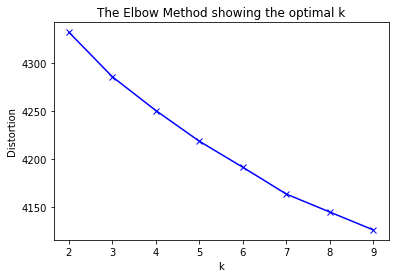

In [32]:
plt.plot(K, kmeans_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

In [33]:
kmeans = KMeans(n_clusters=5, random_state=42)

In [34]:
kmeans.fit(df_new)

KMeans(n_clusters=5, random_state=42)

In [35]:
df_new['cluster_'] = kmeans.labels_

In [37]:
from wordcloud import WordCloud

In [38]:
# Create a list of words for each cluster
cluster_0 = df_new[df_new['cluster_'] == 0].drop('cluster_', axis=1).sum().sort_values(ascending=False)
cluster_1 = df_new[df_new['cluster_'] == 1].drop('cluster_', axis=1).sum().sort_values(ascending=False)
cluster_2 = df_new[df_new['cluster_'] == 2].drop('cluster_', axis=1).sum().sort_values(ascending=False)
cluster_3 = df_new[df_new['cluster_'] == 3].drop('cluster_', axis=1).sum().sort_values(ascending=False)
cluster_4 = df_new[df_new['cluster_'] == 4].drop('cluster_', axis=1).sum().sort_values(ascending=False)

In [39]:
wordcloud_0 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(cluster_0)
wordcloud_1 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(cluster_1)
wordcloud_2 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(cluster_2)
wordcloud_3 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(cluster_3)
wordcloud_4 = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(cluster_4)

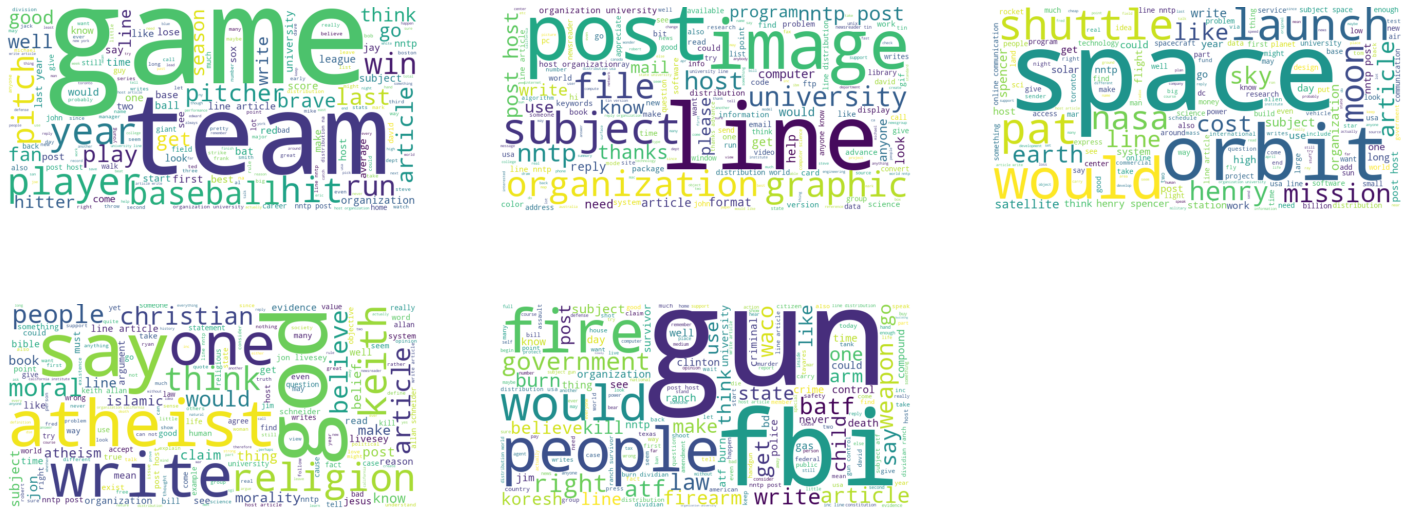

In [40]:
plt.figure(figsize=(25, 10))
plt.subplot(231)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.subplot(232)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.subplot(233)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.subplot(234)
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.axis('off')
plt.subplot(235)
plt.imshow(wordcloud_4, interpolation='bilinear')
plt.axis('off')
plt.show()

Theo quan sát các word cloud ta có thể phân loại được như sau:
wordcloud_0: rec.sport.baseball	
wordcloud_1: comp.graphics
wordcloud_2: sci.space
wordcloud_3: alt.atheism
wordcloud_4: talk.politics.guns

In [41]:
news

,text,target,target_name
0,dani eder subject vandalize sky organization b...,3,sci.space
1,munizb munizb subject space event near los ang...,3,sci.space
2,john f carr subject propose catcher sub rule o...,2,rec.sport.baseball
3,gregory n bond subject give billion first year...,3,sci.space
4,organization university illinois chicago acade...,4,talk.politics.guns
...,...,...,...
4658,pat subject shuttle pennicillin organization e...,3,sci.space
4659,charley wingate subject visit jehovah witness ...,0,alt.atheism
4660,chris rende subject need recommendation image ...,1,comp.graphics
4661,doug loss subject philosophy quest boldly orga...,3,sci.space


In [42]:
#test lại
from sklearn.model_selection import train_test_split
y = news['target'].values
X_train, X_test,y_train,y_test =  train_test_split(X,y,test_size=0.20,random_state=42)
k_means = KMeans(n_clusters=5)
k_means.fit(X_train)
print(k_means.labels_[:])
print(y_train[:])
score = metrics.accuracy_score(y_test,k_means.predict(X_test))
print('Accuracy:{0:f}'.format(score))
k_means.predict(X_test)
print(k_means.labels_[:])
print(y_test[:])

[1 2 0 ... 3 1 3]
[1 2 3 ... 0 2 0]
Accuracy:0.461951
[1 2 0 ... 3 1 3]
[1 1 1 0 2 3 1 2 2 1 1 2 2 0 2 1 1 0 3 2 2 4 2 2 1 4 4 2 0 2 3 3 4 4 1 4 0
 2 3 4 4 2 3 3 1 1 0 1 1 2 4 2 3 2 2 1 2 3 0 0 3 4 0 3 2 2 2 0 4 1 2 0 1 3
 2 0 3 4 0 1 3 3 1 2 3 4 4 1 3 2 3 4 3 1 3 2 1 1 1 4 1 2 4 0 4 4 0 0 0 1 3
 1 3 3 1 0 3 0 2 0 3 1 3 4 3 1 3 4 1 2 2 2 3 4 3 3 2 2 1 1 1 0 2 4 4 1 0 3
 0 3 2 0 1 4 1 3 0 0 2 2 0 0 0 4 3 0 4 4 1 1 1 2 4 1 4 3 1 3 4 1 2 2 1 2 3
 1 1 2 0 0 4 1 4 2 4 1 4 0 3 4 0 4 1 0 2 2 4 0 2 4 4 3 3 1 0 2 3 3 1 4 2 3
 2 3 4 3 3 0 0 4 0 1 0 1 1 2 0 1 3 1 2 2 0 2 1 3 1 2 2 0 3 2 4 4 4 3 4 3 0
 1 0 0 2 1 1 3 4 4 1 0 3 1 0 4 4 4 2 3 0 0 3 3 0 1 2 1 0 1 0 1 4 3 4 4 1 3
 2 2 1 2 3 2 3 1 4 1 0 3 0 1 2 3 0 4 2 3 0 3 4 0 1 3 3 3 1 3 4 3 1 2 0 0 4
 2 4 1 1 1 1 3 3 3 4 0 3 3 2 3 4 3 0 2 4 0 1 0 4 2 3 0 0 4 2 2 3 2 1 4 4 0
 4 2 1 0 1 1 2 1 0 3 1 1 1 1 1 2 1 2 3 1 2 1 3 4 0 4 3 3 1 0 0 3 0 0 1 4 4
 3 0 0 1 0 1 2 4 4 3 2 2 3 3 3 1 3 3 4 3 1 0 1 3 1 2 0 0 4 0 3 1 1 2 4 4 2
 1 3 1 3 1 2 1 3 2 0 2 1 4 1